In [1]:
import numpy as np
import ray
import torch
from torch import nn, optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, TensorDataset
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split

/nfs/home/dwm7542/.conda/envs/mldsrl/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-11-27 15:43:30,569	INFO util.py:159 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [2]:
train_set = np.load('Assignment3-data/train_data.npy', allow_pickle=True)
test_set = np.load('Assignment3-data/test_data.npy', allow_pickle=True)

In [3]:
num_clients = 100
train_labels = []

for i in range(num_clients):
    for g in range(len(train_set[i]['labels'])):
        train_labels.append(train_set[i]['labels'][g])

In [4]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, num_classes):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, num_classes)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [5]:
def split_data(client):
    train_data, val_data, train_labels, val_labels = train_test_split(client['images'], client['labels'], test_size=0.2)
    return train_data, val_data, train_labels, val_labels

In [6]:
def differential_privacy(client, beta):
    
    for idx, image in enumerate(client['images']):
        noise = np.random.laplace(scale=beta, size=image.shape)
        type(client['images'][idx])
        client['images'][idx] = image + noise
        type(client['images'][idx])
        
        
    return client

In [7]:
class Client:
    def __init__(self, client_data):
        
        self.B = 0.065
        
        self.client_data = differential_privacy(client_data, self.B)
        self.train_images, self.val_images, self.train_labels, self.val_labels = split_data(self.client_data)
        
        self.train_images = torch.tensor(np.array(self.train_images)).view(-1, 28*28).to(torch.float32)
        self.val_images = torch.tensor(np.array(self.val_images)).view(-1, 28*28).to(torch.float32)
        self.train_labels = torch.tensor(np.array(self.train_labels)).to(torch.float32)
        self.val_labels = torch.tensor(np.array(self.val_labels)).to(torch.float32)
        
        self.model = NeuralNet(28*28, 62)
        
        self.learning_rate = 1e-4
        
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)
        
        self.train_dataset = TensorDataset(self.train_images, torch.Tensor(self.train_labels).long())
        self.val_dataset = TensorDataset(self.val_images, torch.Tensor(self.val_labels).long())
        
        self.train_loader = DataLoader(self.train_dataset, batch_size=16, shuffle=True)
        self.val_loader = DataLoader(self.val_dataset, batch_size=16, shuffle=True)
        
        self.E = 25

    def train(self, global_weights):
        
        self.model.load_state_dict(global_weights)
        
        self.model.train()
        
        for epoch in range(self.E):
            for images, labels in self.train_loader:
                outputs = self.model(images)
                loss = self.criterion(outputs, labels)
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
        return self.model.state_dict(), len(self.train_loader.dataset)

    def evaluate(self):
        
        self.model.eval()
        
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in self.val_loader:
                outputs = self.model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                
        accuracy = correct / total
        return [accuracy, total]
    
    def receive_global_weights(self, global_weights):
        pass


In [8]:
class Server:
    
    def __init__(self):
        
        self.global_model = NeuralNet(28*28, 62)
        self.C = 0.1
        
        self.num_clients = 100
        
        self.client_weight_bank = []
        
        self.training_round = 0
        
    def sample_clients(self):
        return [random.randint(0, self.num_clients-1) for _ in range(int(self.num_clients * self.C))]
        
    def receive_client_weights(self, client_weights):
        self.client_weight_bank.append(client_weights)
        
    def get_global_weights(self):
        return self.global_model.state_dict()

    def weighted_average(self, client_results):
        self.total_weight = 0
        self.weighted_sum = 0

        for (metric_value, num_samples) in client_results:
            self.total_weight += num_samples
            self.weighted_sum += metric_value * num_samples

        if self.total_weight == 0:
            return 

        self.aggregated_value = self.weighted_sum / self.total_weight
        return self.aggregated_value
    
    def fedAvg(self, client_weights):
        
        self.total_obs = sum(obs for _, obs in client_weights)
        if self.total_obs == 0:
            return
        
        self.federatedAvg = None
        for model_weights, obs in client_weights:
            weight_factor = obs / self.total_obs
            if self.federatedAvg is None:
                self.federatedAvg = {k: v * weight_factor for k, v in model_weights.items()}
            else:
                for k in self.federatedAvg:
                    self.federatedAvg[k] += model_weights[k] * weight_factor

        return self.federatedAvg
    
    def test(self, test_set):
        
        self.test_images = torch.tensor(np.array(test_set[0]['images'])).view(-1, 28*28)
        self.test_labels = torch.tensor(np.array(test_set[0]['labels']))
        
        self.test_dataset = TensorDataset(self.test_images, torch.Tensor(self.test_labels).long())
        
        self.test_loader = DataLoader(self.test_dataset, batch_size=16, shuffle=True)
        
        self.global_model.eval()
        
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in self.test_loader:
                outputs = self.global_model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                
        accuracy = correct / total
        print(f"Test Accuracy: {accuracy}")
        return accuracy
        
        
        
        

In [9]:
num_rounds = 10

server = Server()

weighted_averages = []

for round_id in range(num_rounds):
    
    sample = server.sample_clients()
    
    client_weights = []
    client_results = []
    
    for client_id in sample:
        client = Client(train_set[client_id])

        client_weights.append(client.train(server.get_global_weights()))
        client_results.append(client.evaluate())
        
    weighted_averages.append(server.weighted_average(client_results))
    
    print(f"Communication Round {round_id}: {weighted_averages[-1]}")
    
    weighted_avg_weights = server.fedAvg(client_weights)
    
    server.global_model.load_state_dict(weighted_avg_weights)
    
server.test(test_set)

Communication Round 0: 0.09523809523809523
Communication Round 1: 0.08990536277602523
Communication Round 2: 0.11232449297971919
Communication Round 3: 0.16815476190476192
Communication Round 4: 0.16530278232405893
Communication Round 5: 0.18739903069466882
Communication Round 6: 0.19629057187017002
Communication Round 7: 0.33434190620272314
Communication Round 8: 0.3316412859560068
Communication Round 9: 0.38880706921944036
Test Accuracy: 0.5017636684303352


0.5017636684303352

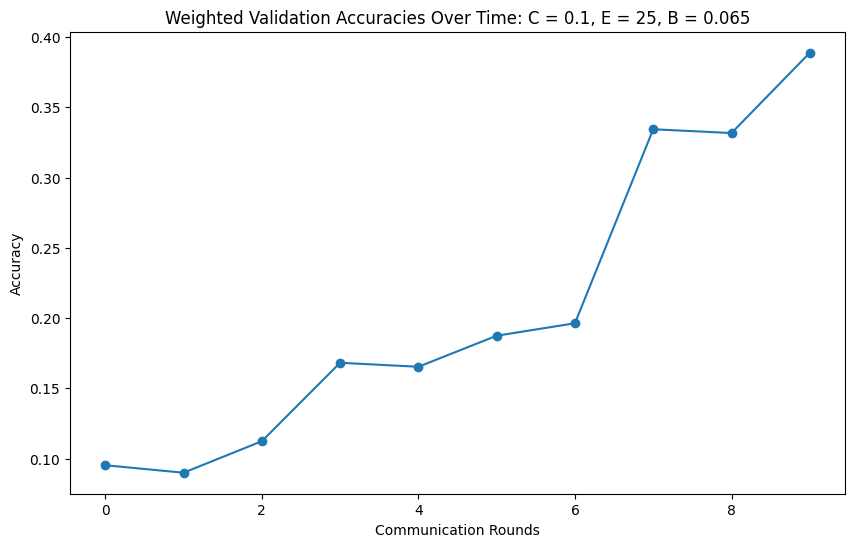

In [10]:
plt.figure(figsize=(10, 6))
plt.plot(weighted_averages, marker='o')

plt.title(f'Weighted Validation Accuracies Over Time: C = {server.C}, E = {client.E}, B = {client.B}')
plt.xlabel('Communication Rounds')
plt.ylabel('Accuracy')

plt.savefig('results/fedavg_acc.png', dpi=300, format='png', bbox_inches='tight')

plt.show()

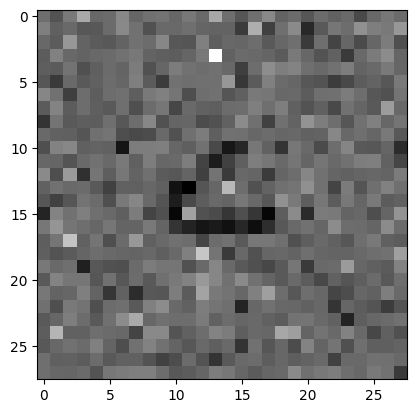

In [22]:
pic = train_set[54]['images'][12]
noise = np.random.laplace(scale=0.2, size=pic.shape)
plt.imshow(pic + noise, 'gray')